In [1]:
import ML_basic_function as fc
from ML_basic_function import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn import cluster
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import time
from sklearn.base import BaseEstimator, TransformerMixin,ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
import inspect, re
from sklearn.preprocessing import PolynomialFeatures
from itertools import product
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm
import gc
from sklearn.feature_selection import VarianceThreshold,r_regression,SelectKBest,f_regression,SelectPercentile,chi2,f_classif,mutual_info_regression,mutual_info_classif,RFE,RFECV,SequentialFeatureSelector,SelectFromModel
from scipy import stats
import scipy
import random
from joblib import dump, load
from scipy.special import digamma
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from hyperopt import hp, fmin, tpe
from numpy.random import RandomState
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score as AUC
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier as GBC
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix

In [2]:
X_train = pd.read_csv("fff/X_train.csv")
X_test = pd.read_csv("fff/X_test.csv")
y_train = pd.read_csv("fff/y_train.csv")
y_test = pd.read_csv("fff/y_test.csv")

In [3]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [4]:
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

In [5]:
clf = load('clf.joblib')
clf_GBDT = load('clf_GBDT.joblib')
clf_xgb = load('clf_xgb.joblib')
clf_tree = load('clf_tree.joblib')
clf_lgbm = load('clf_lgbm.joblib')

In [6]:
data_train = xgb.DMatrix(X_train, y_train)
data_test = xgb.DMatrix(X_test, y_test)

In [7]:
clf_predict_proba = pd.Series(clf.predict_proba(X_test)[:, 1], index=X_test.index)
clf_GBDT_predict_proba = pd.Series(clf_GBDT.predict_proba(X_test)[:, 1], index=X_test.index)
clf_xgb_predict_proba = pd.Series(clf_xgb.predict(data_test), index=X_test.index)
clf_tree_predict_proba = pd.Series(clf_tree.predict_proba(X_test)[:, 1], index=X_test.index)
clf_lgbm_predict_proba = pd.Series(clf_lgbm.predict_proba(X_test)[:, 1], index=X_test.index)

[LightGBM] [Warning] Unknown parameter: max_features


In [45]:
# 定义超参数空间
params_space = {'thr': hp.uniform("thr", 0.4, 0.6), 
                'weight1': hp.uniform("weight1",0,1),
                'weight2': hp.uniform("weight2",0,1),
                'weight4': hp.uniform("weight4",0,1),
                'weight5': hp.uniform("weight5",0,1)
               }

In [46]:
# 定义目标函数
def hyperopt_objective_weight(params):
    thr = params['thr']
    weight1 = params['weight1']
    weight2 = params['weight2']
    weight4 = params['weight4']
    weight5 = params['weight5']

    weights_sum = weight1 + weight2 + weight4 + weight5

    predict_probo_weight = (clf_predict_proba * weight1 + 
                            clf_GBDT_predict_proba * weight2 + 
                            clf_tree_predict_proba * weight4 +
                            clf_lgbm_predict_proba * weight5) / weights_sum

    res_weight = (predict_probo_weight >= thr) * 1

    score = accuracy_score(res_weight, y_test)
    
    return -score

In [47]:
# 定义优化函数
def param_hyperopt_weight(max_evals):
    params_best = fmin(fn = hyperopt_objective_weight,
                       space = params_space,
                       algo = tpe.suggest,
                       max_evals = max_evals, 
                      )    
    return params_best

In [51]:
params_best = param_hyperopt_weight(60000)

100%|███████████████████████████████████████| 60000/60000 [5:06:13<00:00,  3.27trial/s, best loss: -0.9025647318689409]


In [52]:
params_best

{'thr': 0.5206391228471223,
 'weight1': 0.0011813409056066586,
 'weight2': 0.8171992988107522,
 'weight4': 0.12484581578020071,
 'weight5': 0.21172312091239107}

In [21]:
weights_sum = 0.0011813409056066586 + 0.8171992988107522 + 0.12484581578020071 + 0.21172312091239107

predict_probo_weight = (clf_predict_proba * 0.0011813409056066586 + 
                            clf_GBDT_predict_proba * 0.8171992988107522 + 
                            clf_tree_predict_proba * 0.12484581578020071 +
                            clf_lgbm_predict_proba * 0.21172312091239107) / weights_sum

res_weight = (predict_probo_weight >= 0.5206391228471223) * 1

accuracy_score(res_weight, y_test)

0.9025647318689409

In [22]:
precision_score(res_weight, y_test) #精确度

0.8696665889484728

In [23]:
recall_score(res_weight, y_test)

0.9407313997477932

In [24]:
f1_score(res_weight, y_test)

0.9038042161376303

In [25]:
AUC(y_test, predict_probo_weight)

0.9545308096262641

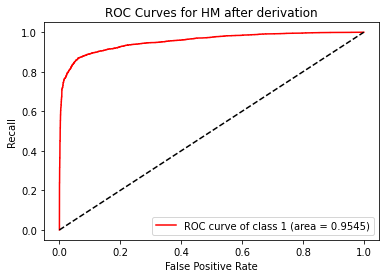

In [26]:
FPR, recall, thesholds = roc_curve(y_test, predict_probo_weight, pos_label = 1)
plt.figure()
plt.plot(FPR, recall, color='red',
         label='ROC curve of class 1 (area = %0.4f)' % AUC(y_test, predict_probo_weight))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('ROC Curves for HM after derivation')
plt.legend(loc="lower right")
plt.savefig("HM_after",dpi=1000)
plt.show()

In [29]:
cm = confusion_matrix(y_test, res_weight)   
print(cm)

[[3625  235]
 [ 559 3730]]


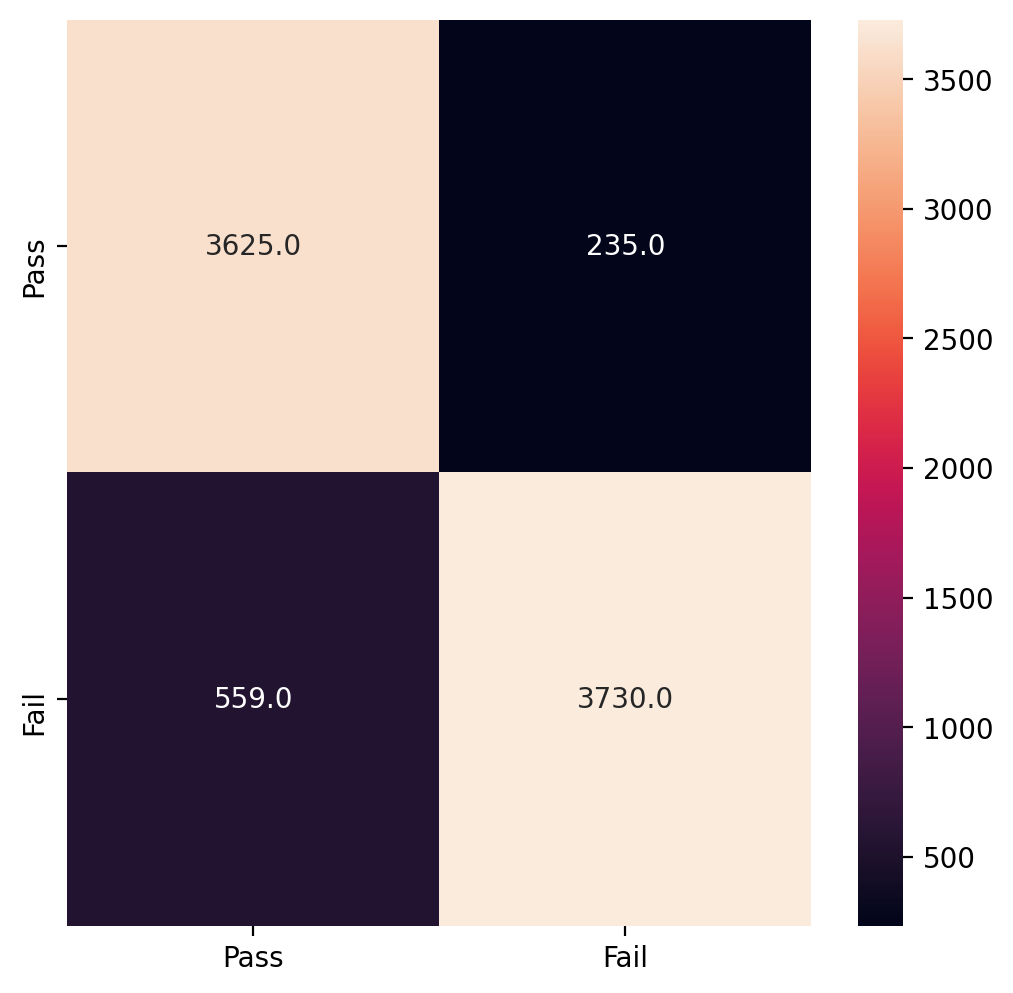

In [40]:
plt.figure(figsize=(6,6), dpi=200)
sns.heatmap (cm, annot = True, fmt = ".1f", xticklabels = ["Pass", "Fail"], yticklabels = ["Pass", "Fail"])
plt.savefig("cm",dpi=200)
#plt.savefig("heatmapp",dpi=1000)